In [31]:
import warnings
warnings.simplefilter('ignore')

In [32]:
import pandas as pd, numpy as np, gc
import matplotlib.pyplot as plt, seaborn as sns

In [33]:
train = pd.read_csv('/kaggle/input/diabetes-prediction-challenge/train.csv')
test = pd.read_csv('/kaggle/input/diabetes-prediction-challenge/test.csv')
print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

train.head(3)

Train Shape: (700000, 26)
Test Shape: (300000, 25)


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0


In [34]:
TARGET = 'diagnosed_diabetes'
BASE = [col for col in train.columns if col not in ['id', TARGET]]
CATS = train.select_dtypes('object').columns.to_list()
NUMS = [col for col in BASE if col not in CATS]
print(f'{len(BASE)} Base Features:{BASE}')

24 Base Features:['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


In [35]:
# check null values for both CATS features
print('NaN Count:', train[CATS].isnull().sum().sum(), '\n')
print(train[CATS].nunique(),'\n')
train[CATS].head(3)

NaN Count: 0 

gender               3
ethnicity            5
education_level      4
income_level         5
smoking_status       3
employment_status    4
dtype: int64 



,gender,ethnicity,education_level,income_level,smoking_status,employment_status
0,Female,Hispanic,Highschool,Lower-Middle,Current,Employed
1,Female,White,Highschool,Upper-Middle,Never,Employed
2,Male,Hispanic,Highschool,Lower-Middle,Never,Retired


In [36]:
# check null values for NUMS Features
print('NaN Count:', train[NUMS].isnull().sum().sum(), '\n')
print(train[NUMS].nunique(),'\n')
train[NUMS].head(3)

NaN Count: 0 

age                                    71
alcohol_consumption_per_week            9
physical_activity_minutes_per_week    565
diet_score                             99
sleep_hours_per_day                    69
screen_time_hours_per_day             151
bmi                                   231
waist_to_hip_ratio                     36
systolic_bp                            71
diastolic_bp                           54
heart_rate                             60
cholesterol_total                     154
hdl_cholesterol                        69
ldl_cholesterol                       151
triglycerides                         228
family_history_diabetes                 2
hypertension_history                    2
cardiovascular_history                  2
dtype: int64 



,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,0,0,0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,0,0,0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,0,0,0


In [37]:
sns.set_style('whitegrid')
plt.rcParams['font.size']=10
plt.rcParams['figure.dpi']=100

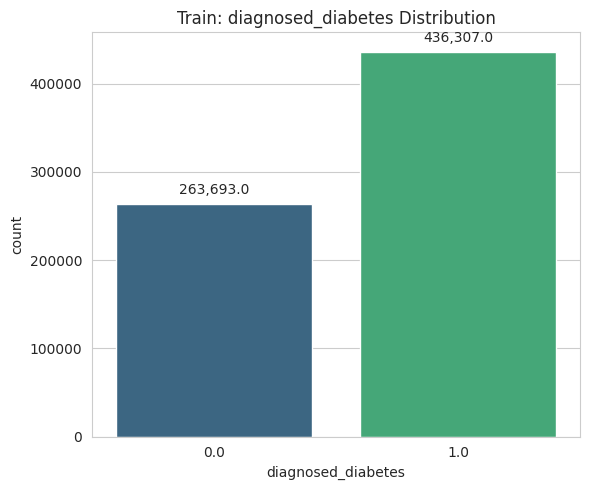

In [38]:
fig, ax = plt.subplots(figsize=(6,5))

# train dataset target distribution
sns.countplot(data=train, x=TARGET, palette='viridis')
ax.set_title(f'Train: {TARGET} Distribution')
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.show()

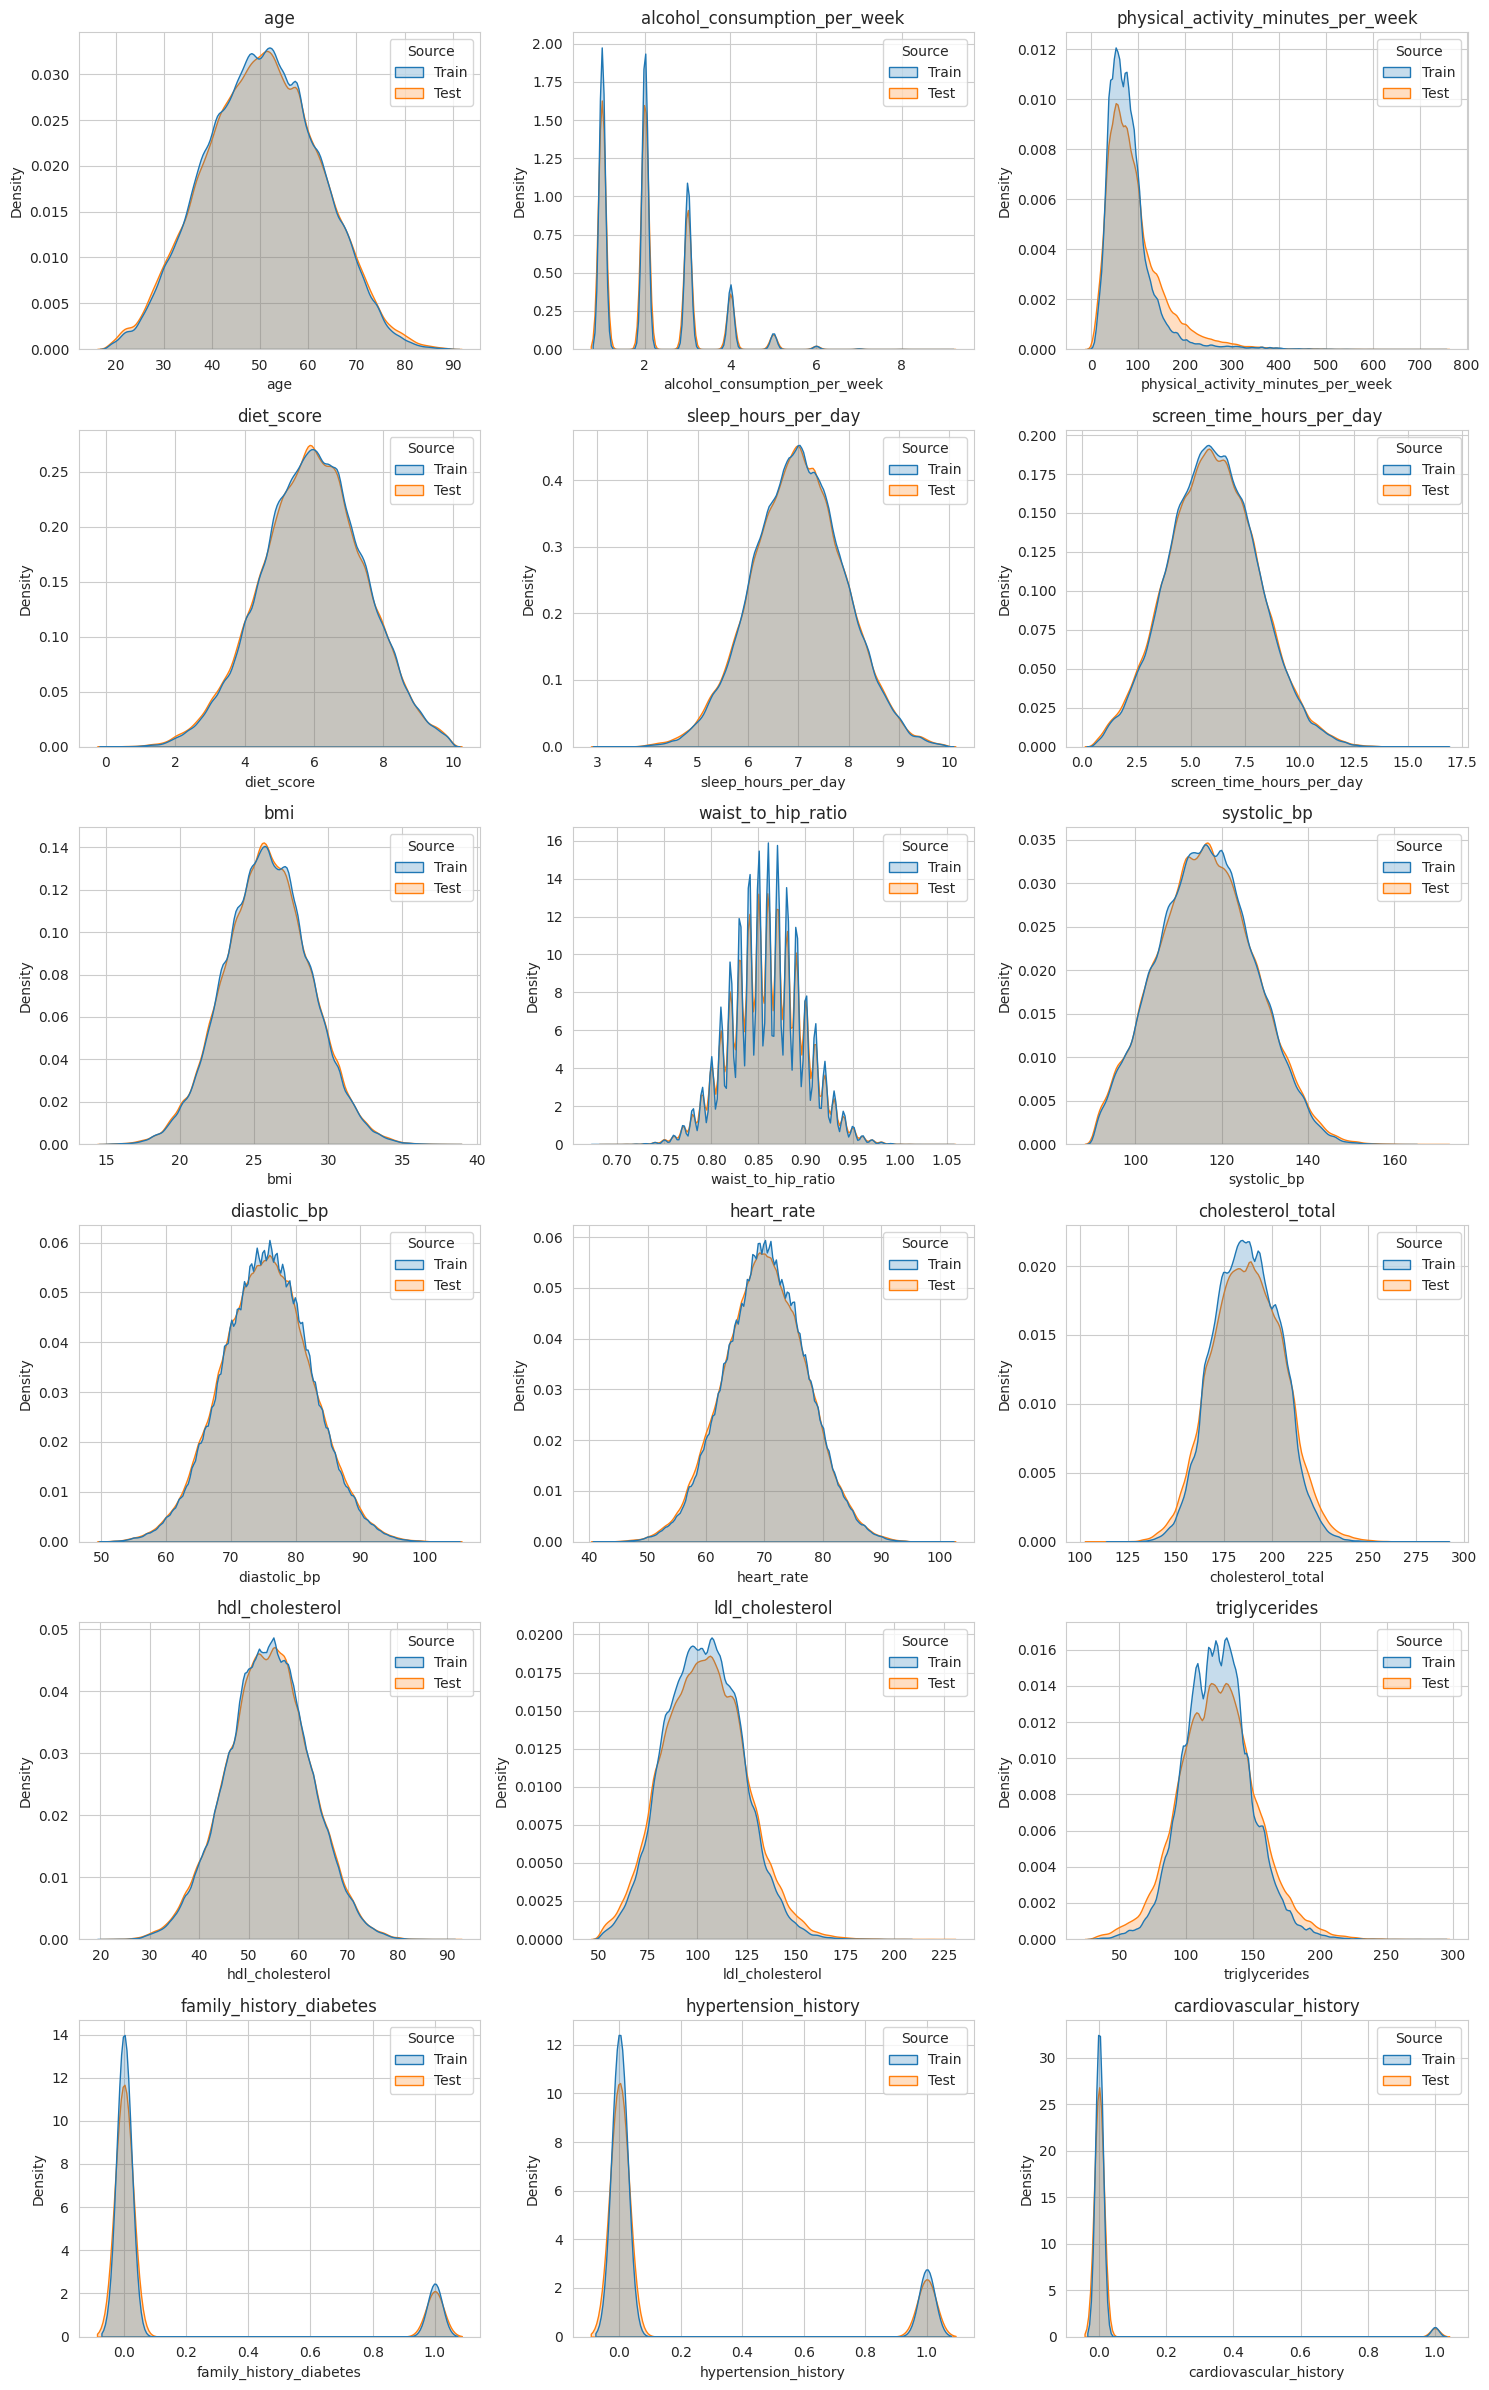

In [39]:
# feature distribution of numeric columns -->
df_plot = pd.concat([
    train[NUMS].assign(Source='Train'),
    test[NUMS].assign(Source='Test')
])
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(NUMS):
    sns.kdeplot(data=df_plot, x=col, hue='Source', ax=axes[i], 
                fill=True, common_norm=False, warn_singular=False)
    axes[i].set_title(col)

for i in range(len(NUMS), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

del df_plot

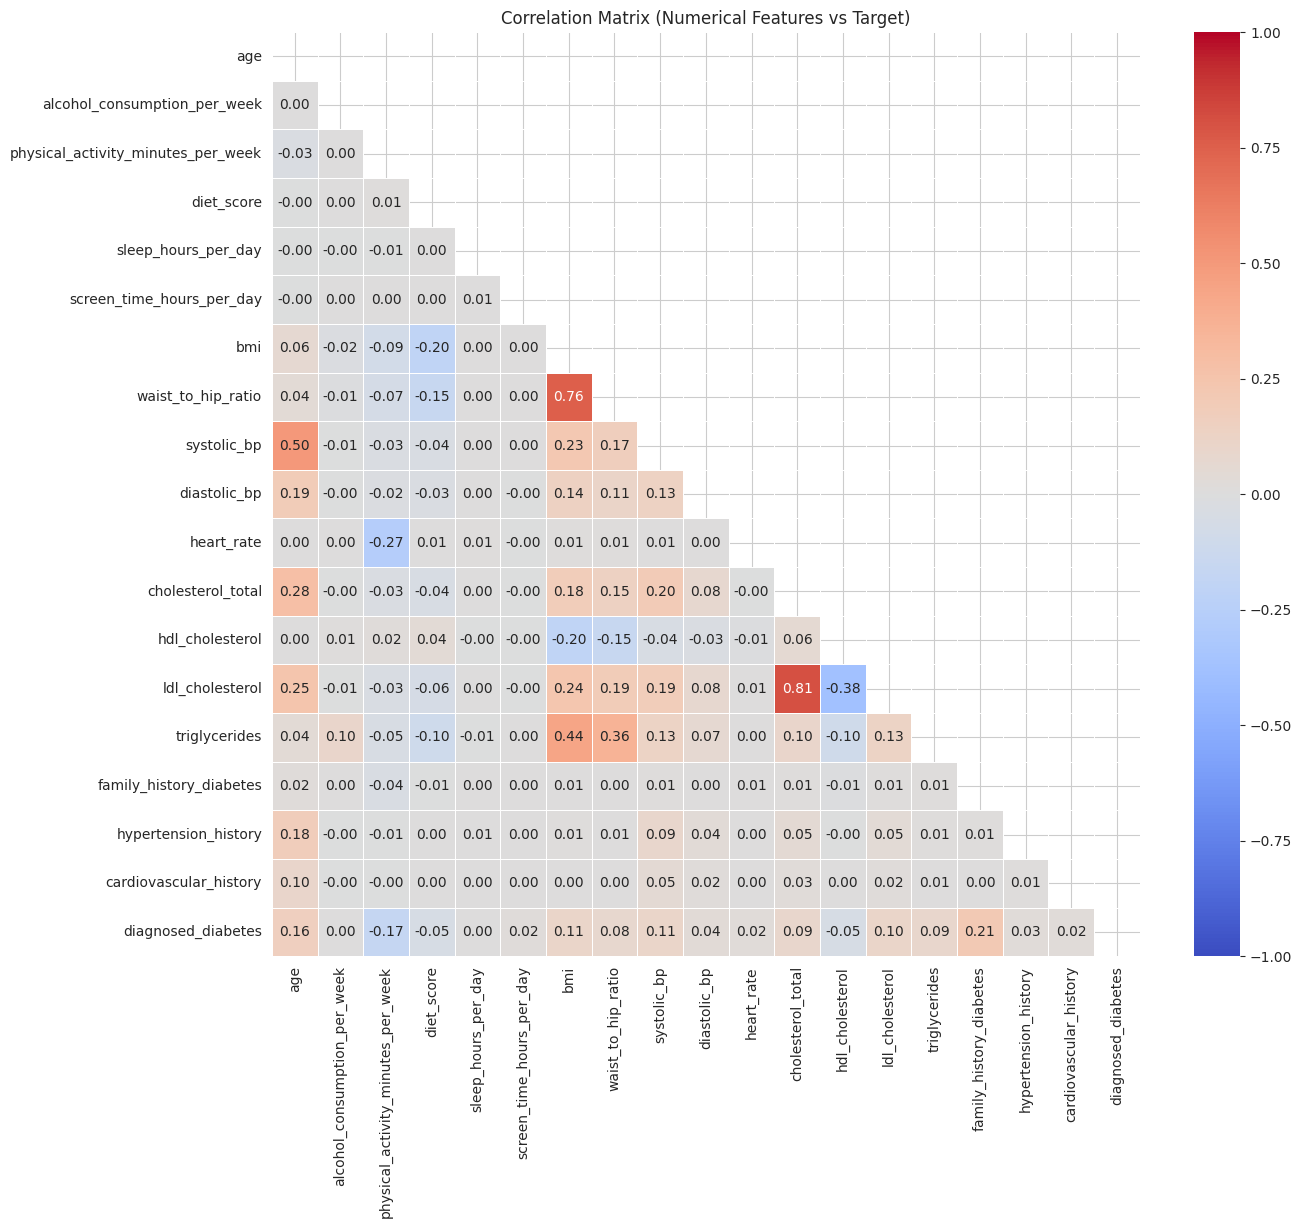

In [40]:
# correlation matrix for numerical features

corr_features = NUMS + [TARGET]
corr_matrix = train[corr_features].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix (Numerical Features vs Target)')
plt.show()


# Model Training

In [41]:
X = train[BASE]
y = train[TARGET]

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold

In [43]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

In [44]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import callback
import gc
import xgboost as xgb

In [45]:

# -----------------------------------------------------
# 0. Helper: Memory Reducer
# -----------------------------------------------------
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    return df

X = reduce_mem_usage(X)
test = reduce_mem_usage(test)
gc.collect()

# -----------------------------------------------------
# 4.3 Training Loop (XGBoost)
# -----------------------------------------------------

# Initialize arrays
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Select TE Columns (Exclude binary features)
TE_COLS = [col for col in NUMS if train[col].nunique() > 2]
print(f"Target Encoding applied to {len(TE_COLS)} features.")

# XGBoost Parameters
xgb_params = {
    'n_estimators': 20000,
    'learning_rate': 0.01,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'auc',
    'device': 'cuda',           # GPU (optional)
    'enable_categorical': True  # Native Categorical Support
}

print(f"Starting Training...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    
    # 1. Split Data
    X_train, y_train = X.iloc[train_idx].copy(), y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx].copy(), y.iloc[val_idx]
    X_test_fold = test[BASE].copy() 
    
    # -----------------------------------------------------
    # A. Target Encoding (Augment Numerical Features)
    # -----------------------------------------------------
    if len(TE_COLS) > 0:
        TE = TargetEncoder(cols_to_encode=TE_COLS, cv=5, smooth='auto', aggs=['mean', 'count'], drop_original=False)
        X_train = TE.fit_transform(X_train, y_train)
        X_val = TE.transform(X_val)
        X_test_fold = TE.transform(X_test_fold)
    
    # -----------------------------------------------------
    # B. Factorize CATS & Prepare for Native Support
    # -----------------------------------------------------
    for c in CATS:
        # 1. Factorize (Returns NumPy Array)
        combined = pd.concat([X_train[c], X_val[c], X_test_fold[c]])
        combined_encoded, _ = combined.factorize()
        
        # 2. Assign back to DataFrame to convert to Series
        X_train[c] = combined_encoded[:len(X_train)]
        X_val[c] = combined_encoded[len(X_train):len(X_train)+len(X_val)]
        X_test_fold[c] = combined_encoded[len(X_train)+len(X_val):]

        # 3. Cast to Category
        X_train[c] = X_train[c].astype('category')
        X_val[c] = X_val[c].astype('category')
        X_test_fold[c] = X_test_fold[c].astype('category')

    # -----------------------------------------------------
    # C. Train Model (XGBClassifier)
    # -----------------------------------------------------
    model = XGBClassifier(**xgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=200,
        verbose=500
    )
    
    # Predict
    val_preds = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_preds
    test_preds += model.predict_proba(X_test_fold)[:, 1] / kf.get_n_splits()
    
    fold_score = roc_auc_score(y_val, val_preds)
    print(f"Fold {fold+1} AUC: {fold_score:.5f}")

    if len(TE_COLS) > 0: del TE
    gc.collect()

print("-" * 30)
print(f"OOF AUC: {roc_auc_score(y, oof_preds):.5f}")

Target Encoding applied to 15 features.
Starting Training...
[0]	validation_0-auc:0.69801
[500]	validation_0-auc:0.72804
[1000]	validation_0-auc:0.72991
[1500]	validation_0-auc:0.73062
[2000]	validation_0-auc:0.73087
[2500]	validation_0-auc:0.73094
[2653]	validation_0-auc:0.73094
Fold 1 AUC: 0.73097
[0]	validation_0-auc:0.69354
[500]	validation_0-auc:0.72627
[1000]	validation_0-auc:0.72814
[1500]	validation_0-auc:0.72886
[2000]	validation_0-auc:0.72921
[2500]	validation_0-auc:0.72933
[2555]	validation_0-auc:0.72935
Fold 2 AUC: 0.72935
[0]	validation_0-auc:0.69659
[500]	validation_0-auc:0.72696
[1000]	validation_0-auc:0.72874
[1500]	validation_0-auc:0.72954
[2000]	validation_0-auc:0.72985
[2500]	validation_0-auc:0.73000
[2993]	validation_0-auc:0.73003
Fold 3 AUC: 0.73005
[0]	validation_0-auc:0.69543
[500]	validation_0-auc:0.72685
[1000]	validation_0-auc:0.72886
[1500]	validation_0-auc:0.72964
[2000]	validation_0-auc:0.73002
[2500]	validation_0-auc:0.73020
[2962]	validation_0-auc:0.73016

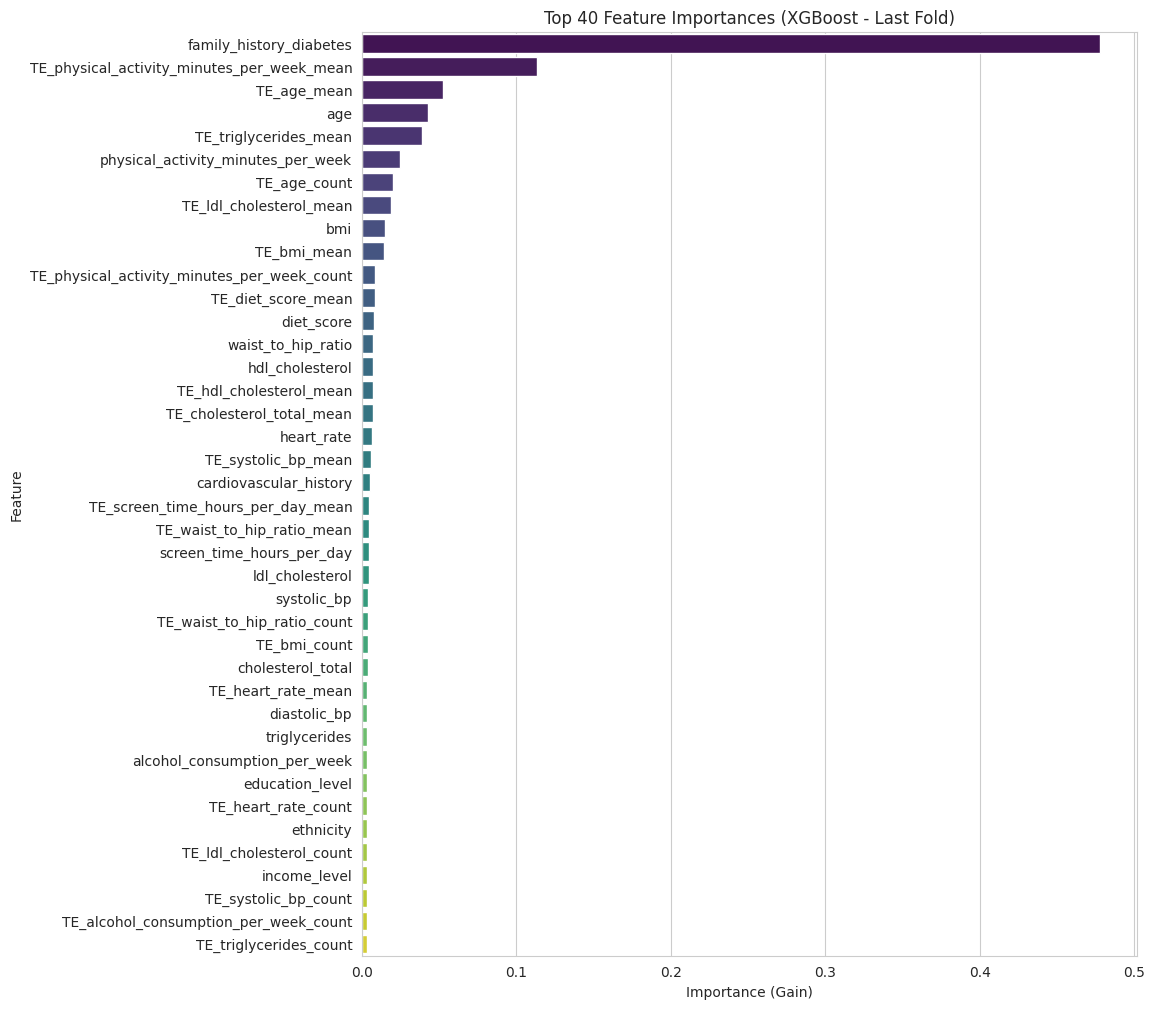

In [46]:
# Extract importances from the last trained model
# (Note: Ideally we average importances across all folds, but the last fold serves as a good proxy for a baseline)
imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(data=imp_df.head(40), x='Importance', y='Feature', palette='viridis')
plt.title('Top 40 Feature Importances (XGBoost - Last Fold)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.show()

Submission and OOF files saved successfully.
Submission Shape: (300000, 2)


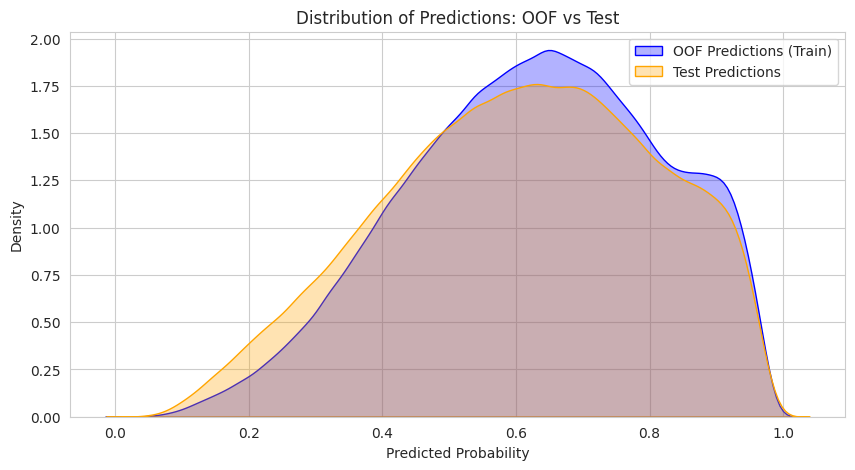

,id,diagnosed_diabetes
0,700000,0.490591
1,700001,0.734480
2,700002,0.794688
3,700003,0.380641
4,700004,0.917660


In [48]:
# 1. Create Submission DataFrame
sub = pd.read_csv('/kaggle/input/diabetes-prediction-challenge/sample_submission.csv')
sub[TARGET] = test_preds
sub.to_csv('submission.csv', index=False)

# 2. Save OOF Predictions (for Ensembling)
# OOF dataframe creating ensures we match the correct IDs
oof_df = pd.DataFrame()
oof_df['id'] = train['id']
oof_df[TARGET] = y
oof_df['pred'] = oof_preds
oof_df.to_csv('oof_predictions.csv', index=False)

print('Submission and OOF files saved successfully.')
print(f'Submission Shape: {sub.shape}')

# 3. Sanity Check: Distribution Plot
plt.figure(figsize=(10, 5))
sns.kdeplot(oof_df['pred'], label='OOF Predictions (Train)', fill=True, color='blue', alpha=0.3)
sns.kdeplot(sub[TARGET], label='Test Predictions', fill=True, color='orange', alpha=0.3)
plt.title('Distribution of Predictions: OOF vs Test')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

sub.head()